In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import os

from tqdm import tqdm



/home/s.gostilovich/.venv/lib64/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Plot NIPS MNIST alpha

In [2]:
model_type = 'VAE'
str_rec_metrics = """
MSE: 0.0213(0.0212);   PSNR: 16.73 (16.73);   Rec FID: 32.15 (31.16)
MSE: 0.0086(0.0083);   PSNR: 20.65 (20.80);   Rec FID: 11.07 (10.34)
MSE: 0.0042(0.0039);   PSNR: 23.81 (24.04);   Rec FID: 8.99 (8.28)
MSE: 0.0022(0.0021);   PSNR: 26.50 (26.84);   Rec FID: 7.18 (6.51)
"""
str_gen_fid  = """
FID gm1: 59.33;   FID gm4: 43.61
FID gm1: 34.59;   FID gm4: 21.20
FID gm1: 31.29;   FID gm4: 17.89
FID gm1: 36.97;   FID gm4: 21.81
"""
alpha_list = [1/(10**(i+1)) for i in range(4)]


model_type = 'LRAE'
str_rec_metrics = """
MSE: 0.0035(0.0033);  PSNR: 24.60 (24.76);    Rec FID: 8.50 (7.83)
MSE: 0.0024(0.0023);   PSNR: 26.17 (26.48);   Rec FID: 7.97 (7.31)
MSE: 0.0031(0.0028);   PSNR: 25.05 (25.54);   Rec FID: 7.99 (7.32)
MSE: 0.0036(0.0033);   PSNR: 24.42 (24.75);   Rec FID: 8.08 (7.49)
"""
str_gen_fid  = """
FID gm1: 27.79;   FID gm4: 16.51
FID gm1: 31.39;   FID gm4: 18.98
FID gm1: 30.92;   FID gm4: 18.16
FID gm1: 32.37;   FID gm4: 19.47
"""
x_list = [3.2, 1, 0.5] +  [1/(10**(i+1)) for i in range(4)]
x_label = 'alpha'

print(x_list)

[3.2, 1, 0.5, 0.1, 0.01, 0.001, 0.0001]


In [3]:
model_type = 'VAE'
str_rec_metrics = """
MSE: 0.0042(0.0039); PSNR: 23.81 (24.04);   Rec FID: 8.99 (8.28)
MSE: 0.0045 (0.0043);   PSNR: 23.47 (23.62);   Rec FID: 9.03 (8.39)
MSE: 0.0049 (0.0048);   PSNR: 23.11 (23.18);   Rec FID: 9.13 (8.51)
MSE: 0.0058 (0.0057);   PSNR: 22.40 (22.42);   Rec FID: 10.08 (9.51)
MSE: 0.0069 (0.0070);   PSNR: 21.59 (21.56);   Rec FID: 11.73 (11.32)
"""
str_gen_fid  = """
FID gm1: 31.29; FID gm4: 17.89
FID gm1: 32.75;   FID gm4: 19.90
FID gm1: 36.48;   FID gm4: 21.03
FID gm1: 37.33;   FID gm4: 24.63
FID gm1: 41.17;   FID gm4: 27.53
"""

x_label = 'batch_size'

x_list = [32, 128, 256, 512, 1024]


print(x_list)

[32, 128, 256, 512, 1024]


In [8]:
model_type = 'VAE'
str_rec_metrics = """
MSE: 0.0069 (0.0069);   PSNR: 21.63 (21.60);   Rec FID: 11.38 (11.08)
MSE: 0.0060 (0.0060);   PSNR: 22.24 (22.25);   Rec FID: 10.40 (9.83)
MSE: 0.0054 (0.0053);   PSNR: 22.67 (22.74);   Rec FID: 9.66 (9.16)
MSE: 0.0051 (0.0050);   PSNR: 22.92 (23.02);   Rec FID: 9.35 (8.79)
MSE: 0.0049 (0.0047);   PSNR: 23.11 (23.26);   Rec FID: 9.26 (8.64)
MSE: 0.0047 (0.0045);   PSNR: 23.32 (23.49);   Rec FID: 9.07 (8.44)
MSE: 0.0045 (0.0044);   PSNR: 23.43 (23.59);   Rec FID: 8.93 (8.30)
"""
str_gen_fid  = """
FID gm1: 40.82;   FID gm4: 27.93
FID gm1: 38.59;   FID gm4: 23.64
FID gm1: 36.98;   FID gm4: 22.14
FID gm1: 36.04;   FID gm4: 22.17
FID gm1: 36.82;   FID gm4: 23.11
FID gm1: 34.46;   FID gm4: 19.38
FID gm1: 34.45;   FID gm4: 21.98
"""

x_label = 'epoch'
x_list = [50 + i*25 for i in range(7)]
x_list

[50, 75, 100, 125, 150, 175, 200]

In [9]:
def split_metric_test_train(metric):
    metric_name = metric.strip().split(':')[0]
    test_train = metric.strip().split(':')[1].strip().strip(')').split('(')
    test = float(test_train[0].strip())
    train = float(test_train[1].strip())
    # print(metric_name, test, train)
    return test, train, metric_name


def split_metric(metric):
    metric_name = metric.strip().split(':')[0]
    test = metric.strip().split(':')[1].strip()
    test = float(test)
    return test, metric_name

def udpate_list_dict(key, value, dict_={}):
    if key not in dict_.keys():
        dict_[key] = []
    dict_[key] += [value]
    return dict_ 


In [10]:

data_dict = {}

lines = str_rec_metrics.strip().split('\n')
for line in lines:
    metrics = line.strip().split(';')
    for i, metric in enumerate(metrics):
        test, train, metric_name = split_metric_test_train(metric)
        key = metric_name+'_train'
        udpate_list_dict( metric_name+'_test', test, dict_=data_dict)
        udpate_list_dict( metric_name+'_train', train, dict_=data_dict)
 
lines = str_gen_fid.strip().split('\n')       
for line in lines:
    metrics = line.strip().split(';')
    for i, metric in enumerate(metrics):
        value, metric_name = split_metric(metric)
        udpate_list_dict( metric_name, value, dict_=data_dict)
        # udpate_list_dict( metric_name+'_train', train, dict_=data_dict)       
        
        
        
data_dict




{'MSE_test': [0.0069, 0.006, 0.0054, 0.0051, 0.0049, 0.0047, 0.0045],
 'MSE_train': [0.0069, 0.006, 0.0053, 0.005, 0.0047, 0.0045, 0.0044],
 'PSNR_test': [21.63, 22.24, 22.67, 22.92, 23.11, 23.32, 23.43],
 'PSNR_train': [21.6, 22.25, 22.74, 23.02, 23.26, 23.49, 23.59],
 'Rec FID_test': [11.38, 10.4, 9.66, 9.35, 9.26, 9.07, 8.93],
 'Rec FID_train': [11.08, 9.83, 9.16, 8.79, 8.64, 8.44, 8.3],
 'FID gm1': [40.82, 38.59, 36.98, 36.04, 36.82, 34.46, 34.45],
 'FID gm4': [27.93, 23.64, 22.14, 22.17, 23.11, 19.38, 21.98]}

Text(0.5, 0.98, 'VAE')

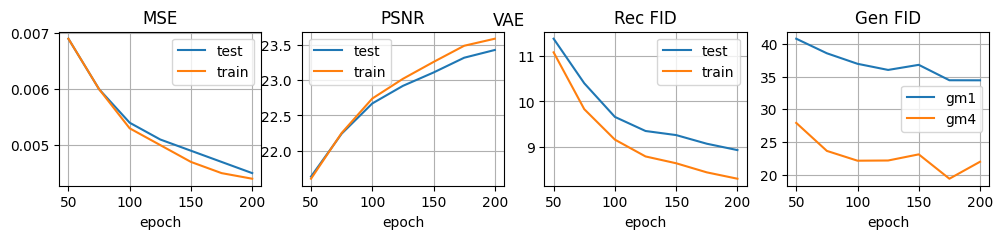

In [12]:
# MSE
plt.figure(figsize=[12, 2])
plt.subplot(1, 4, 1)
keys = ['MSE_test','MSE_train']
for key in keys:
    plt.plot(x_list, data_dict[key], label=key.split('_')[1])
# plt.plot(alpha_list, data_dict[key], label=key)
# plt.gca().set_xscale('log')
# plt.gca().set_xscale('log')
plt.gca().set_xlabel(x_label)
# plt.gca().invert_xaxis()
plt.title(keys[0].split('_')[0])
plt.grid()
plt.legend()


# PSNR
plt.subplot(1, 4, 2)
keys = ['PSNR_test','PSNR_train']
for key in keys:
    plt.plot(x_list, data_dict[key], label=key.split('_')[1])
# plt.plot(alpha_list, data_dict[key], label=key)
# plt.gca().set_xscale('log')
# plt.gca().set_xscale('log')
plt.gca().set_xlabel(x_label)
# plt.gca().invert_xaxis()
plt.title(keys[0].split('_')[0])
plt.grid()
plt.legend()

# Rec FID
plt.subplot(1, 4, 3)
keys = ['Rec FID_test','Rec FID_train']
for key in keys:
    plt.plot(x_list, data_dict[key], label=key.split('_')[1])
# plt.plot(alpha_list, data_dict[key], label=key)
# plt.gca().set_xscale('log')
# plt.gca().set_xscale('log')
plt.gca().set_xlabel(x_label)
# plt.gca().invert_xaxis()
plt.title(keys[0].split('_')[0])
plt.grid()
plt.legend()


# Gen FID
# plt.figure(figsize=[4, 2])
plt.subplot(1, 4, 4)
keys = ['FID gm1','FID gm4']
for key in keys:
    plt.plot(x_list, data_dict[key], label=key.split(' ')[1])
# plt.plot(alpha_list, data_dict[key], label=key)
# plt.gca().set_xscale('log')
# plt.gca().set_xscale('log')
plt.gca().set_xlabel(x_label)
# plt.gca().invert_xaxis()
plt.title('Gen '+ keys[0].split(' ')[0])
plt.grid()
plt.legend()

plt.suptitle(model_type)

# others

In [117]:

b = {1:1, 2:2} | {3:3}
b

{1: 1, 2: 2, 3: 3}